### Attention
Je ne suis pas épidémiologiste, mais doctorant en science des données. A la lecture de [l'excellent article de Thomas Pueyo](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca), j'ai voulu m'inspirer de son travail, avec un code ouvert, dans le cas de la France, en français, à la date du 14 mars 2020. Ce travail n'est PAS un article scientifique revu par les pairs, mais une tentative d'estimation faite en quelques heures. Qui plus est même si le modèle utilisé correspond très bien aux observations, il est possible qu'il soit un peu trop simpliste. A prendre en considération donc.

## Loi exponentielle

On peut modéliser le phénomène de propagation du COVID-19 par une fonction exponentielle. L'article de Wikipedia sur la [croissance exponentielle](https://en.wikipedia.org/wiki/Exponential_growth) est bien fait: on peut prouver assez facilement qu'une croissance exponentielle peut s'écrire sous différentes formes:
$$x(t) = x_0e^{kt} = x_0e^{t/\tau} = x_02^{t/T} = x_0(1+\frac{r}{100})^{t/p}$$
avec x(t) le nombre de cas au temps t, x0 le nombre de cas à t=0, k le taux de croissance effectif, tau la période "e-folding", r le taux de croissance intrinsèque pour une periode p, T la période de "doublage" (le delta temps qu'il faut pour que x(t) double).

## Modéliser la propagation en France (au 14/03/20)
Je me base sur les données extraites du [Wordlometer](https://www.worldometers.info/coronavirus/). Visualisons tout d'abord l'évolution du nombre de cas:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
data = pd.read_csv('covid_confirmed.csv')

In [3]:
# we extract only the timeserie for france
france_df = data[data['Province/State'] == 'France'].iloc[:, 4:]
france_df = france_df.T
france_df = france_df.reset_index()
france_df.rename(columns={france_df.columns[0]: "Time", france_df.columns[1]: "Cases Number" }, inplace = True)
france_df['Time'] = (pd.to_datetime(france_df['Time'].str.strip(), format='%m/%d/%y'))
france_df.head()

,Time,Cases Number
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,2
3,2020-01-25,3
4,2020-01-26,3


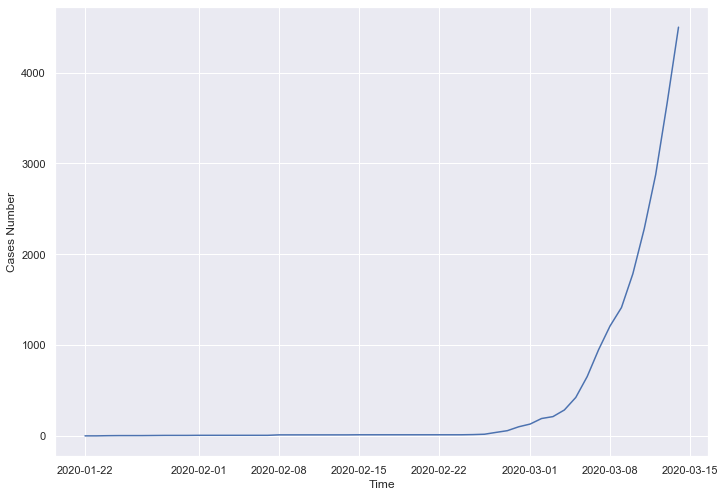

In [4]:
sns.lineplot(data=france_df, x='Time', y='Cases Number')

Maintenant, nous allons construire notre modèle de croissance exponentielle et choisir les paramètres pour qu'il corresponde le mieux possible aux données.

In [5]:
x_numpy = np.array(france_df['Time'])

# we transform date to int to fit the model
x_numpy = (x_numpy - x_numpy[0]).astype('timedelta64[D]').astype('int')
y_numpy = np.array(france_df['Cases Number'])

R² = 0.9976140854576636


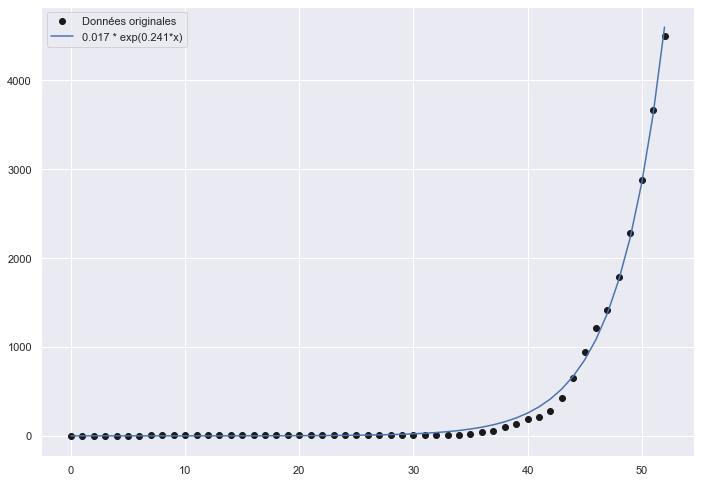

In [6]:
def exp_func(x, a, b):
    return a * np.exp(b * x) 

popt, pcov = curve_fit(exp_func, x_numpy, y_numpy, p0=(1, 1e-6))



residuals = y_numpy - exp_func(x_numpy, *popt)
ss_res = np.sum(residuals**2)

ss_tot = np.sum((y_numpy-np.mean(y_numpy))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R² = {r_squared}")

plt.figure()
plt.plot(x_numpy, y_numpy, 'ko', label="Données originales")
label = "{:.3f} * exp({:.3f}*x)".format(*popt)
plt.plot(x_numpy, exp_func(x_numpy, *popt), 'b-', label=label)
plt.legend()
plt.show()


Notre modèle nous donne donc x0 = 0.017 et k=0.241
Il est simple, et bien sûr criticable, mais semble pourtant bien correspondre à la réalité du moment, avec un R² de 0.997 (à 1 il correspondrait parfaitement à la réalité, il modèlise donc très bien les observations actuelles).

**Precision**: La croissance exponentielle ne sera pas infinie bien sûr. Elle sera soit limitée par les mesures que nous prendrons, soit lorsque l'ensemble de personnes non infectées et non-immunisées sera trop faible. On l'a vu en Chine, les mesures de confinement ont changé le modèle, stoppant la croissance exponentielle. D'ici quelques temps les mesures prises ici changeront la courbe à mesure qu'elles auront empéché la propagation.


D'après les équations du début, on peut facilement montrer que:

$$k = \frac{ln(1 + \frac{r}{100})}{p} = \frac{ln(2)}{T}$$

T correspond au temps qu'il faut pour que le nombre de cas double, il vaut ici:

In [7]:
k = popt[1]
print(f"T = {np.log(2) / k}")

T = 2.880887901598439


Le nombre de cas détectés double donc tous les **2.9** jours en France, pour l'instant.  
Fixons p à 1 pour connaître le taux de croissance intrinsèque journalier r:

In [8]:
r = 100 * (np.exp(k) - 1)
print(f"r = {r}")

r = 27.201457983622014


Ceci signifie que chaque jour, le nombre de cas détectés augmente de **27%**.

## Regarder ailleurs pour mieux prévoir ici

On peut considérer que jusqu'à aujourd'hui (14/03/20) les mesures prises par le gouvernement ne sont pas encore effectives (à partir du 16/03/20 pour la fermeture des écoles universités). Il en est de même pour les recommandations du télétravail, puisque l'annonce du gouvernement a eu lieu jeudi soir: les employés des entreprises se sont réunis vendredi pour décider de la meilleure manière de s'adapter à la situation. On peut donc considérer raisonnablement que la courbe va continuer sur la même lancée les prochains jours.

### Une latence pour l'impact des mesures prises
La période d'incubation est estimée à environ 5 jours, en se basant sur ces [publications](https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus) (section incubation period, je n'ai considéré que les données de publications avec relecture par les pairs). Ceci signifie que les gens ne commencent à avoir les symptômes qu'après 5 jours. Ainsi, toute mesure de confinement prise ne commencera à avoir un impact qu'après ce délai, au mieux: même en enfermant les gens chez eux, s'ils ont attrapé le virus celui-ci se développe et ils seront de toutes façons malades dans 5 jours environ. De plus les premiers symptômes n'envoient pas instantanément les malades dans les hôpitaux, c'est un phénomène plutôt continu, donc cette latence est en fait supérieure à 5 jours. Pour la Chine il fallut environ 11-12 jours après le shutdown de Wuhan (voir graphique 11 [ici](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca)).  
  
C'est cette latence qui "fait mal" en Italie notamment, où les mesures de confinement ont réellement été prises le 9/03: la propagation poursuit sa lancée, le nombre de cas augmente drastiquement, et avec lui le nombre de décès, en ayant l'impression d'être impuissants face à l'ampleur du phénomène. Les mesures de confinement ralentiront le phénomène, simplement il faut passer le cap de cette "latence".

### Prédire le nombre de cas détectés les prochains jours.
Etant donnée cette latence, le nombre d'infectés va probablement continuer d'une manière similaire. Ainsi, on va pouvoir donner une estimation grossière du nombre de cas en utilisant notre modèle. Faisons le sur 12 jours, c'est à dire la durée qui a été nécessaire en chine pour que les mesures aient un impact.

In [14]:
X_test = np.array(range(52,65))
y_pred = exp_func(X_test, *popt)

day_of_month = 14

for i, value in enumerate(y_pred):
    print(f"Le {day_of_month + i} mars on peut prédire un nombre de cas diagnostiqués d'environ {int(value)}.")


Le 14 mars on peut prédire un nombre de cas diagnostiqués d'environ 4597.
Le 15 mars on peut prédire un nombre de cas diagnostiqués d'environ 5848.
Le 16 mars on peut prédire un nombre de cas diagnostiqués d'environ 7439.
Le 17 mars on peut prédire un nombre de cas diagnostiqués d'environ 9463.
Le 18 mars on peut prédire un nombre de cas diagnostiqués d'environ 12037.
Le 19 mars on peut prédire un nombre de cas diagnostiqués d'environ 15311.
Le 20 mars on peut prédire un nombre de cas diagnostiqués d'environ 19476.
Le 21 mars on peut prédire un nombre de cas diagnostiqués d'environ 24774.
Le 22 mars on peut prédire un nombre de cas diagnostiqués d'environ 31513.
Le 23 mars on peut prédire un nombre de cas diagnostiqués d'environ 40085.
Le 24 mars on peut prédire un nombre de cas diagnostiqués d'environ 50989.
Le 25 mars on peut prédire un nombre de cas diagnostiqués d'environ 64859.
Le 26 mars on peut prédire un nombre de cas diagnostiqués d'environ 82501.


### Estimer le nombre de cas rééls actuels
Bien évidemment étant donné le nombre limité de personnes que l'on peut diagnostiquer, et du fait que la majorité des personnes tombe malade sans forcement savoir qu'elles sont atteintes du COVID-19, le nombre de personne réellement malades est bien supérieur. On peut reprendre l'analyse de [Thomas Pueyo](https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca) avec les données actuelles, pour donner une estimation du nombre de cas actuels rééls dans la nature. Le délai moyen entre l'infection et la mort est en moyenne d'environ 17 jours (voir [ici](https://docs.google.com/spreadsheets/d/17YyCmjb2Z2QwMiRRwAb7W0vQoEAiL9Co0ARsl03dSlw/copy?usp=sharing)).  
  
Dans de bonnes conditions de soins comme en France (pour le moment), on a une mortalité probablement d'au moins 2% (nombres de personnes décédés / nombre de personnes atteintes). "Au moins" car les personnes atteintes peuvent encore décéder avant d'être des cas "clos". Ainsi, pour x décès aujourd'hui, on peut estimer à **environ x * 100/2 = 4550 personnes malades il y a 17 jours. Aujourd'hui nous avons 4499 malades déclarés.** Cette estimation du nombre de cas d'il y a 17 jours parait donc  plausible au vu des données actuelles. Etant donné qu'il n'y a pas d'impact des mesures prises par le gouvernement entre il y a 17 jours et maintenant, on peut appliquer le taux de croissance de notre modèle pour estimer le nombre de malades aujourd'hui (on fait donc l'hypothèse que la proportion de personnes malades se faisant diagnostiquer est constante). On trouve ainsi qu'ajourd'hui nous avons comme estimation du nombre de cas actuels, puisqu'il y a actuellement **91** personnes décédées:

In [12]:
died = 91
x_17_before = died * 100 / 2

estimation_real_cases = int(x_17_before* (1 + float(r) / 100) ** 17)
print(f"Aujourd'hui nous avons donc environ {estimation_real_cases} nombre de cas.")


Aujourd'hui nous avons donc environ 271879 nombre de cas.


Le nombre de personnes actuellement atteintes par le virus dépend du taux de mortalité, mais cette estimation nous dit
qu'elle se compte déjà probablement en **centaines de millliers**. 

Notons que l'estimation de la mortalité peut grimper jusqu'à 4-5% dans le cas où les moyens présents pour les malades ne sont pas suffisants (voir Hubei). 

## Conclusion
**Il ne faut pas prendre la situation à la légère.** 
**Limiter la propagation est une question de vie ou de mort pour les personnes fragiles**. Empêcher la surcharge des hôpitaux est surement le plus important pour limiter le nombre de décès.

**Conseils**: Nettoyez vos téléphones. Une part très importante de la population utilise son téléphone de manière compulsive toute la journée. L'utiliser, se laver les mains puis le réutiliser amène à de la contamination: nettoyez vos téléphones ! Et restez chez vous, autant que possible. 

**Update du 15/03/20**: On peut se mouiller un peu plus. Ce dimanche 15 mars, les élections municipales ont été maintenues. Qui plus est il semblerait que beaucoup de gens aient voulu "féter" le dernier soir d'ouverture des bars ce samedi. Il est donc raisonnable de penser qu'avant un ralentissement, dans environ 12-15 jours, il y aura un superpic de cas dû à ces deux évènements. Ceci sera problématique, puisque on aprochera probablement des 80k cas diagnostiqués, la population pourrait commencer à mal vivre l'isolement, et surtout à avoir une sensation d'inutilité des mesures, à cause de ce délai. Il faut que les gens comprennent ce phénomène de latence, pour mieux réagir.